<a href="https://colab.research.google.com/github/cy-rules/Data-Science/blob/main/CyruRuleU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import io

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U3proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU3proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU2proj.ipynb"

# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups

**Task**:

Two parts:

1. Propose a data set that's compatible with a hierarchical model structure built with pymc, and that potentially has some dependence between subgroups within the data set. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror and at least one hyperprior.
- Your model must have at least one seperate prior for each subgroup of the data set, and a at least one shared hyperior for all the groups.
- Any student may use the following data set: [basketball2324](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). I recommend trying to model TRB (total rebounds) by player position (pos). Also, I recommend pandas query function to splice and clean the data.



Guidlines:

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough. There is an execption to this rule for unit 4: [NBA player data from the 2023-2024 season](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). Other seasons are allowed as well.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- All students are allowed to use this data set: [NBA player data from the 2023-2024 season](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). Why? This is could lead to similar analysis as the soccer data analysis--basically, I think this data set will work well with the models we ran in class. Let me know if you have questions about downloading and cleaning the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Want an example? The Unit4NotesAK *is* your example! You are expected to be somewhere between a half and three-quarters as detailed--but more is always welcome.

- I didn't totally understand the chemical shift context--which means you don't have to totally understand the context of your data either! You should try to learn as you go, though.


Hi! As you may know, some people get paid enough to live playing basketball. Some of the very best such people play in the NBA, and I would like to try and predict the salary of an NBA player based on the position that they play (of the standard five positions: Point Guard, Shooting Guard, Small Forward, Power Forward, and Center).

I have a bunch of data of players playing in the current season and their salary for this current season. Lets start by visualizing.

In [76]:
salary_data = pd.read_csv('https://raw.githubusercontent.com/cy-rules/Data-Science/refs/heads/main/Salaries.csv')

In [77]:
salary_data

,Player,Tm,2024-25,Pos
0,Stephen Curry,GSW,55761216,PG
1,Joel Embiid,PHI,51415938,C
2,Nikola Jokić,DEN,51415938,C
3,Kevin Durant,PHO,51179021,SF
4,Bradley Beal,PHO,50203930,SG
...,...,...,...,...
456,Malik Fitts,IND,555216,PF
457,Mamadi Diakite,MEM,464050,PF
458,Didi Louzada,POR,268032,SF
459,AJ Griffin,HOU,250000,SF


Imma use a violin plot to compare the salary distributions across the positions

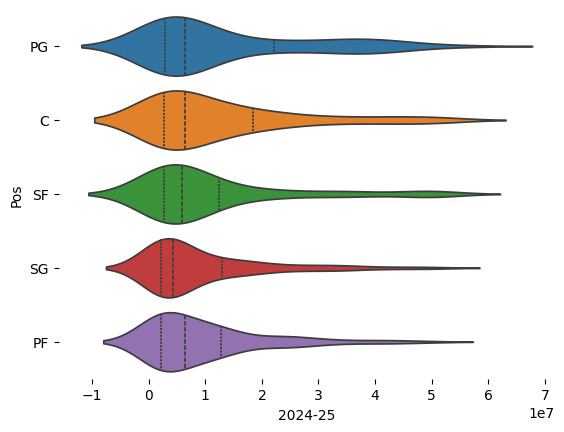

In [78]:
sns.violinplot(salary_data, x='2024-25', y='Pos', inner='quart',hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

Firstly, I want to say that I object to the ordering of the positions, but I don't know how to fix it easily.

So, this data is really interesting. It seems like regardless of position, the lowe end of players gets paid very similarly (quick aside, I have no idea why the x values continue into the negatives, because these are dollar amount salaries) we can see this in that the lower quartile line is in almost the same place for all 3 plots. However, some positions have much longer tails than others, with there being more very highly paid point guards and centers than any other position (we can see this in the much high upper quartile line).

I think a good likelihood to use for this instance would be the log-normal distribution. It is continuous and has only positive support, which makes sense for salaries, while also being able to account for the positive skew I'm pretty sure is present in my data. I considered a gamma distribution, but I think log-normal will give me more flexibility.

Let's get started!

In [79]:

#identifies all the different positions in our data set
#and stores that information, plus original info, in the variable pos_encode
pos_encode = pd.Categorical(salary_data['Pos'])
pos_encode

['PG', 'C', 'C', 'SF', 'SG', ..., 'PF', 'PF', 'SF', 'SF', 'PG']
Length: 461
Categories (5, object): ['C', 'PF', 'PG', 'SF', 'SG']

Again, another unfortunate ordering of the positions

In [80]:
#Replaces all the position names with a number in the variable aa_idx
pos_idx = pos_encode.codes
pos_idx

array([2, 0, 0, 3, 4, 3, 4, 0, 3, 3, 3, 1, 2, 3, 0, 0, 2, 4, 2, 2, 4, 2,
       1, 1, 2, 0, 2, 1, 2, 2, 3, 2, 3, 4, 3, 4, 2, 2, 3, 0, 2, 4, 0, 4,
       4, 1, 2, 3, 2, 0, 1, 4, 2, 4, 1, 4, 0, 3, 1, 3, 4, 4, 1, 0, 1, 2,
       2, 1, 1, 4, 3, 1, 2, 0, 1, 4, 1, 2, 0, 4, 3, 2, 2, 4, 0, 0, 0, 0,
       3, 4, 3, 3, 2, 4, 4, 0, 1, 3, 4, 4, 1, 4, 1, 4, 4, 4, 4, 3, 4, 1,
       3, 0, 1, 4, 0, 4, 0, 0, 2, 1, 1, 2, 4, 3, 4, 1, 2, 2, 0, 1, 4, 1,
       0, 1, 3, 1, 1, 4, 0, 3, 2, 0, 0, 1, 4, 3, 4, 1, 0, 1, 4, 3, 2, 1,
       0, 1, 1, 1, 4, 2, 2, 4, 3, 4, 2, 0, 2, 1, 3, 0, 4, 3, 2, 3, 4, 2,
       2, 2, 0, 1, 3, 4, 3, 3, 1, 1, 3, 4, 4, 3, 3, 3, 0, 1, 1, 1, 3, 4,
       3, 1, 2, 3, 1, 2, 3, 4, 1, 4, 4, 3, 4, 3, 0, 4, 1, 4, 2, 2, 3, 1,
       2, 1, 4, 3, 2, 0, 4, 4, 1, 4, 0, 3, 1, 4, 4, 0, 4, 3, 1, 3, 3, 2,
       1, 3, 3, 0, 0, 0, 0, 2, 2, 4, 4, 3, 2, 2, 3, 2, 0, 4, 3, 2, 1, 4,
       4, 4, 4, 0, 2, 0, 4, 4, 2, 2, 0, 0, 1, 4, 4, 1, 3, 3, 3, 3, 4, 4,
       3, 0, 4, 3, 2, 1, 4, 4, 2, 2, 1, 4, 0, 2, 3,

In [81]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
pos_coords = {"pos": pos_encode.categories}
pos_coords

{'pos': Index(['C', 'PF', 'PG', 'SF', 'SG'], dtype='object')}

Also, now Im going to just get some more quantitative information out of that violin plot so I can better inform my decisions.

In [82]:
salary_data.groupby('Pos')['2024-25'].describe()

,count,mean,std,min,25%,50%,75%,max
Pos,,,,,,,,
C,68.0,1.276456e+07,1.353538e+07,2019699.0,2677492.00,6418200.0,18468750.0,51415938.0
PF,93.0,9.987101e+06,1.052420e+07,464050.0,2087519.00,6362520.0,12768960.0,48787676.0
PG,82.0,1.374440e+07,1.450081e+07,100000.0,2853810.00,6475538.5,22223837.0,55761216.0
SF,90.0,1.135568e+07,1.342286e+07,250000.0,2630431.00,5919446.0,12466980.0,51179021.0
SG,128.0,9.623449e+06,1.088630e+07,702310.0,2235832.25,4311390.0,12980184.0,50203930.0


array([[<Axes: title={'center': '2024-25'}>]], dtype=object)

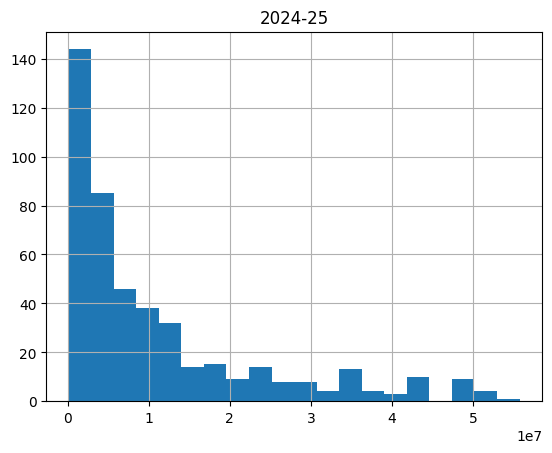

In [83]:
salary_data.hist(bins=20)

In [84]:
salary_data.describe()

,2024-25
count,4.610000e+02
mean,1.123133e+07
std,1.248801e+07
min,1.000000e+05
25%,2.413560e+06
50%,5.756880e+06
75%,1.409258e+07
max,5.576122e+07


Now we can start thinking about how we want to set up this model.

The log-normal distribution has two parameters, μ and σ, which represent the mean and standard deviation of the natural log of the distribution.

The meadian of the distribution is exp(μ), so I'm expecting mu values roughly between 12.5 and 13.5 based on that (e^12.5 is about 270 thousand and e^13.5 is roughly 730 thousand). However, our mean is much greater than that, which is where sigma comes in. the mean is exp(μ + (σ^2)/2), so based on that, and considering how much variance I want, I anticipate σ values between 1.2 and 2.6. This will also help me get a skew that I think is appropriate.

I'm bored of theorizing what values might work, so I'll just try some.

In [85]:
with pm.Model(coords=pos_coords) as sal_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 13, sigma = 5)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)
    σ_mu = pm.Normal('σ_mu', mu = 1.4, sigma = .5)
    σ_sd = pm.HalfNormal('σ_sd', sigma = 1)

    # priors. For mu, I'm fine with a normal distribution centered around the values that give me reasonable medians.
    # Even though the median doesn't scale linearly through that range, I don't actually know where within it makes sense,
    # so theres no point in skewing to one side or the other
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "pos")

    #Unlike in the original example, sigma does a lot of legwork here, I expect the standard deviation to be high
    #and for the data to be skewed, so I'm making hyperpriors for it too.
    #I'm also choosing a truncated normal instead of a half normal because I don't want the mode to be 0 (values less than 1 make no sense).
    σ = pm.TruncatedNormal('σ',
                  mu = σ_mu,
                  sigma = σ_sd,
                  lower = 1,
                  dims = "pos")

    #likelihood; same as before
    y = pm.LogNormal('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  observed = salary_data['2024-25'])

    #cs for chemshift, h for heirarchical
    idata_salary = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 104 divergences after tuning. Increase `target_accept` or reparameterize.


That's a lot of divergences

Let's see what it did


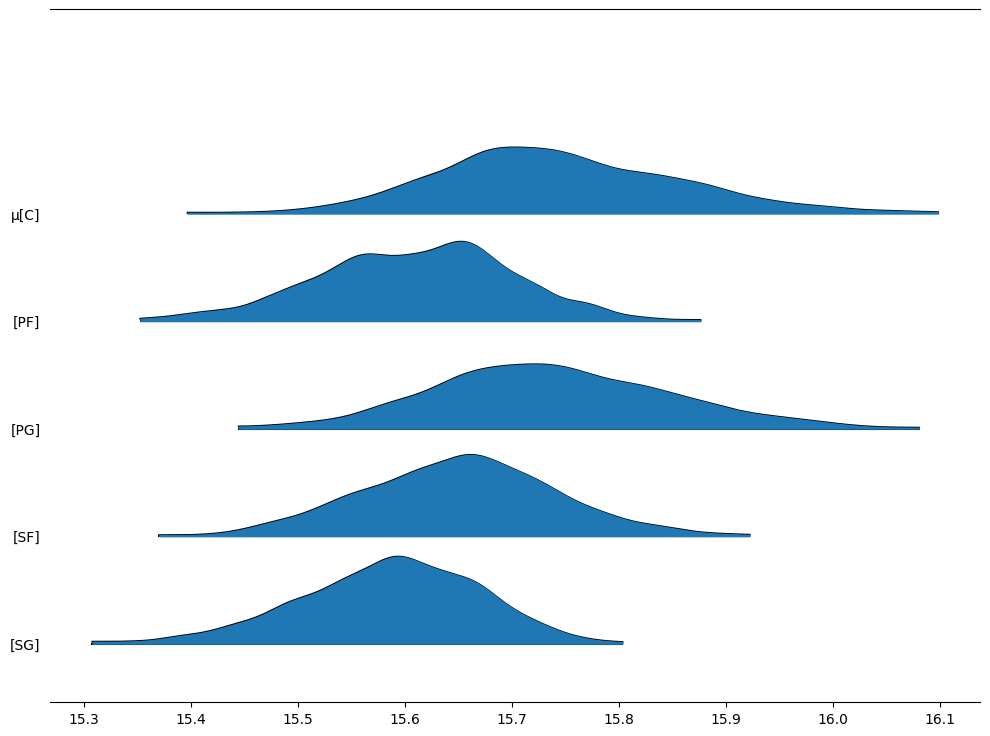

In [86]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_salary, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

I notice that there is a spike in all of these means at about the same value (15.6-15.7). That may be significant

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_mu'}>,
        <Axes: title={'center': 'σ_mu'}>],
       [<Axes: title={'center': 'σ_sd'}>,
        <Axes: title={'center': 'σ_sd'}>]], dtype=object)

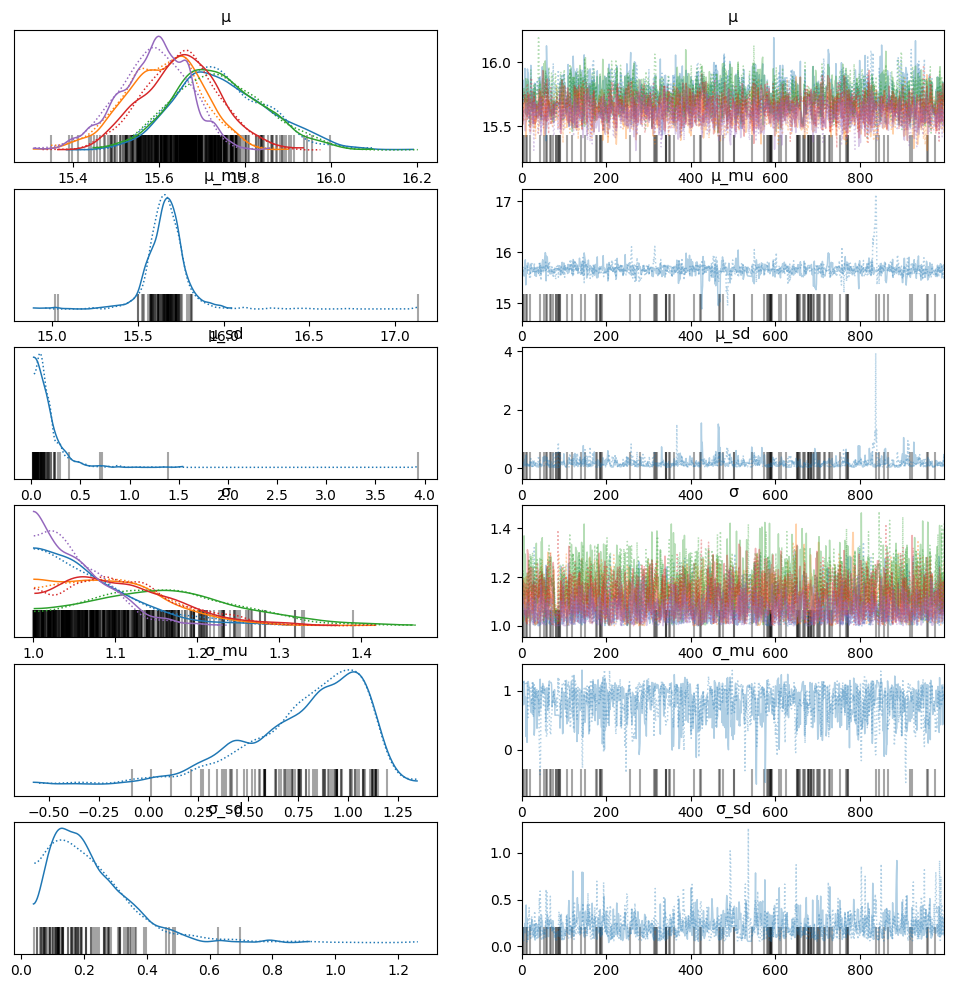

In [87]:
az.plot_trace(idata_salary)

In [88]:
az.rhat(idata_salary)

<xarray.Dataset> Size: 152B
Dimensions:  (pos: 5)
Coordinates:
  * pos      (pos) <U2 40B 'C' 'PF' 'PG' 'SF' 'SG'
Data variables:
    μ        (pos) float64 40B 1.001 0.9999 1.002 1.0 1.001
    μ_mu     float64 8B 1.0
    μ_sd     float64 8B 1.005
    σ        (pos) float64 40B 1.002 1.003 1.003 1.001 1.002
    σ_mu     float64 8B 1.002
    σ_sd     float64 8B 1.002

array([<Axes: title={'center': 'μ_mu'}>, <Axes: title={'center': 'μ_sd'}>,
       <Axes: title={'center': 'σ_mu'}>, <Axes: title={'center': 'σ_sd'}>],
      dtype=object)

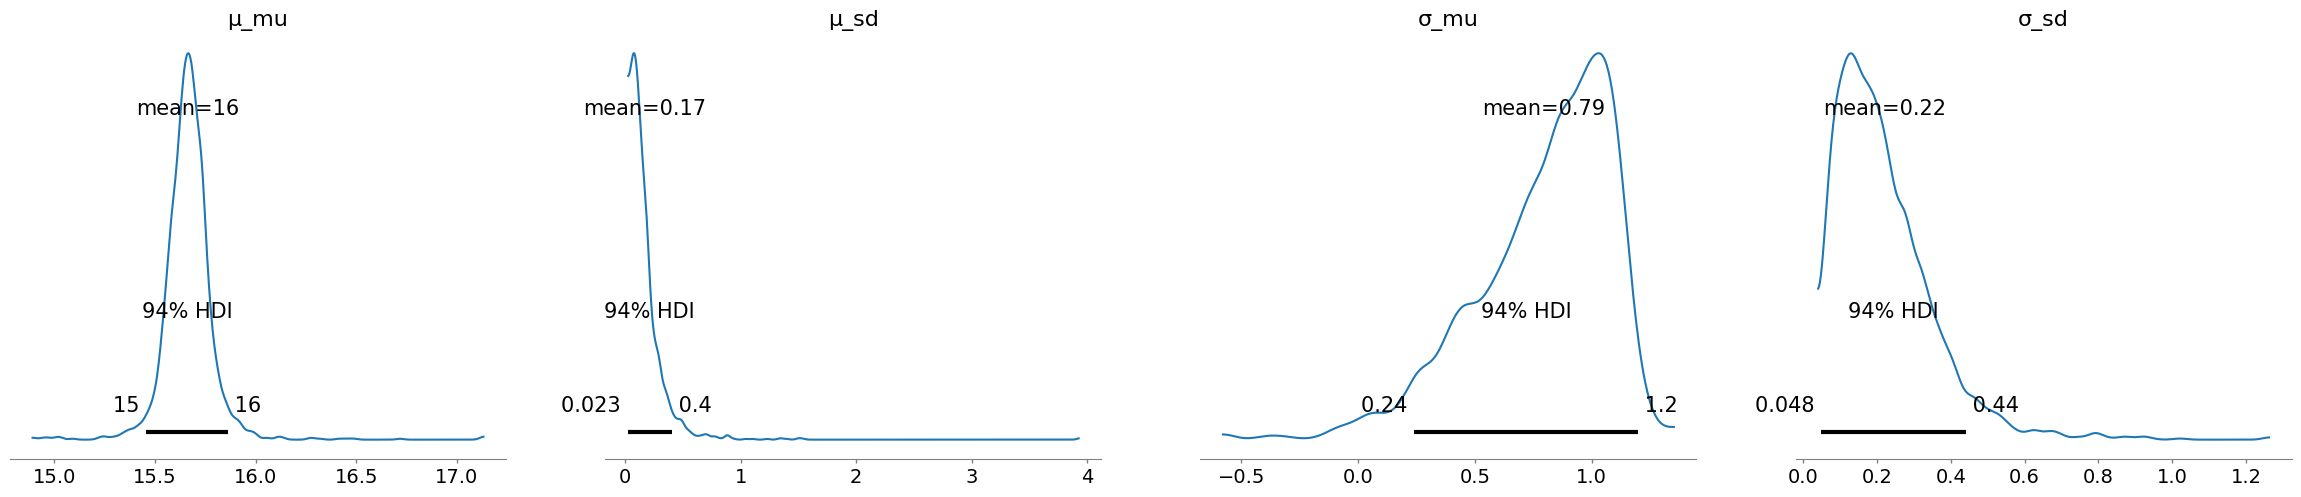

In [89]:
az.plot_posterior(idata_salary, var_names=['μ_mu', 'μ_sd', 'σ_mu', 'σ_sd'])

Ok so it really didn't appreciate any of that. I have noticed a structural problem with my setup. I can't read, and thus though 10^6 was 100,000 instead of 1,000,000. This means that I set my target range for mu way way too low. I'm gonna see what happens if I just move the mean of μ_mu up to something that makes sense. I also am going to make some smarter choices about my sigma parameter (making things half normals instead of normal or truncated normal). I'm also turning σ into a halfnormal on the advice of my teacher. Additionally, I had a very small standard deviation of my σ_sd prior before, so I'll make that (and all my other priors) much more forgiving just to try and reduce the impact of user stupidity.

In [90]:
with pm.Model(coords=pos_coords) as sal_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all positions
    μ_mu = pm.Normal('μ_mu', mu = 16, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)
    σ_sd = pm.HalfNormal('σ_sd', sigma = 10)

    # priors. For mu, I'm fine with a normal distribution centered around the values that give me reasonable medians.
    # Even though the median doesn't scale linearly through that range, I don't actually know where within it makes sense,
    # so theres no point in skewing to one side or the other
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "pos")

    #Apparently I was wrong before and it's still unwise to have sigma be a truncated normal or something like it.
    #So instead I'm using a half-normal
    σ = pm.HalfNormal('σ',
                  sigma = σ_sd,
                  dims = "pos")

    #likelihood; same as before
    y = pm.LogNormal('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  observed = salary_data['2024-25'])

    #salary for salary
    idata_salary = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


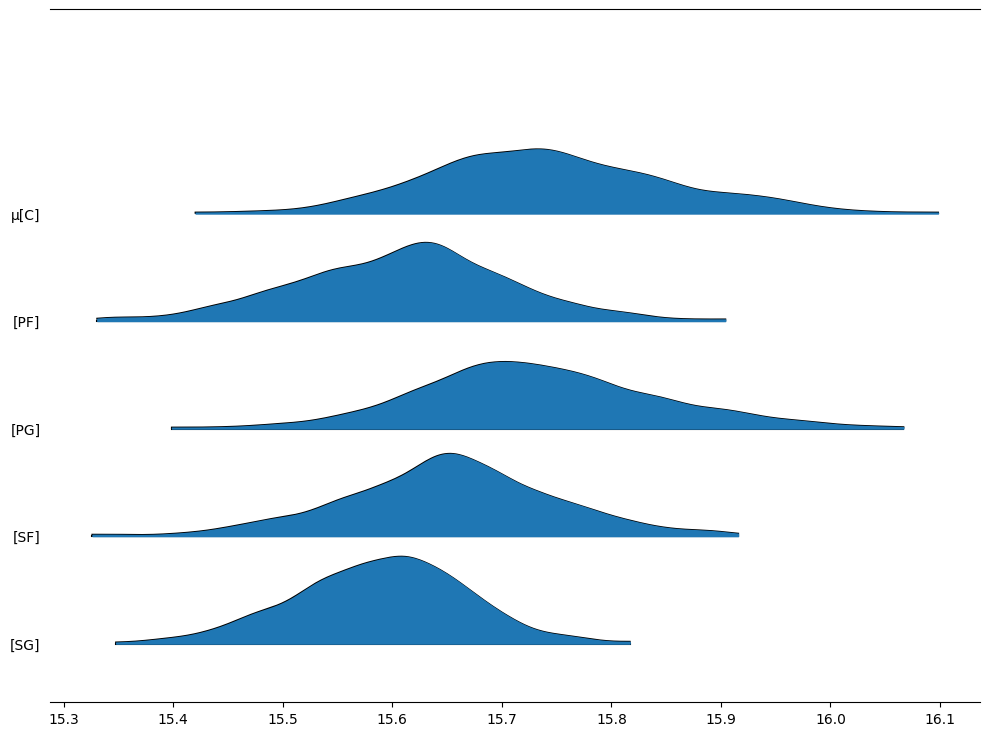

In [91]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_salary, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

The model is kind of uncertain about it's mu values. I would prefer there be less spread here, but I think the high spread is jointly the result of a relatively small dataset and the very weak priors I had. Still, as it stands, this model is saying "I'm pretty sure the median point guard earns between 4 and 9 million a year," which is a pretty big range.

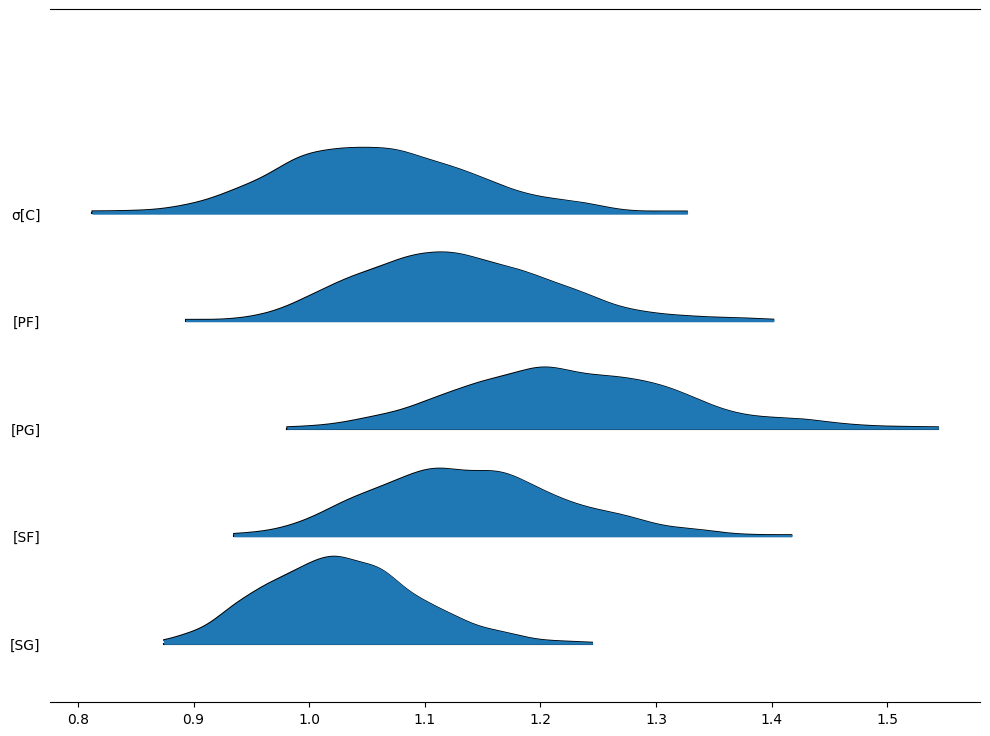

In [92]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_salary, kind="ridgeplot",
                      var_names='σ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Again, really big spread but really loose priors. Since these means tend to be not that close to 0, I'm debating changing my prior for sigma to a gamma distribution or something like one

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_sd'}>,
        <Axes: title={'center': 'σ_sd'}>]], dtype=object)

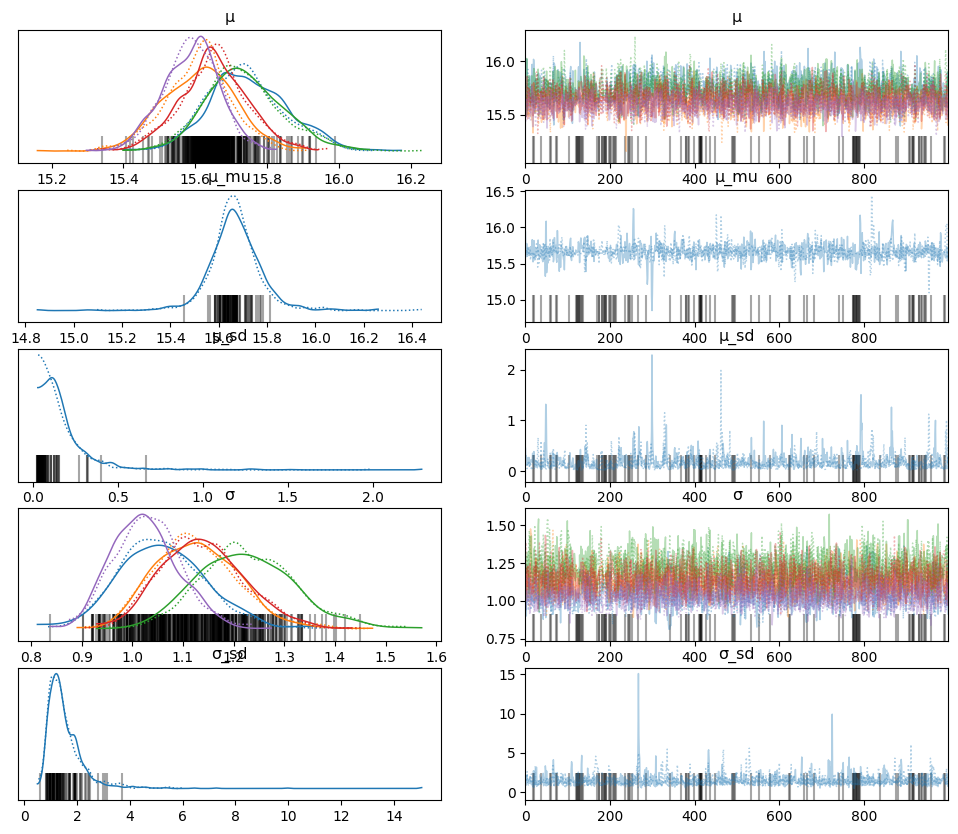

In [93]:
az.plot_trace(idata_salary)

In [94]:
az.rhat(idata_salary)

<xarray.Dataset> Size: 144B
Dimensions:  (pos: 5)
Coordinates:
  * pos      (pos) <U2 40B 'C' 'PF' 'PG' 'SF' 'SG'
Data variables:
    μ        (pos) float64 40B 1.004 1.007 1.002 1.0 1.001
    μ_mu     float64 8B 1.003
    μ_sd     float64 8B 1.006
    σ        (pos) float64 40B 1.001 1.0 1.0 1.003 1.005
    σ_sd     float64 8B 1.001

Ok so of our 10 main variables there are 2 that are in the "acceptable range" of rhat values [1,1.001]. That isn't great, but better than before.

array([<Axes: title={'center': 'μ_mu'}>, <Axes: title={'center': 'μ_sd'}>,
       <Axes: title={'center': 'σ_sd'}>], dtype=object)

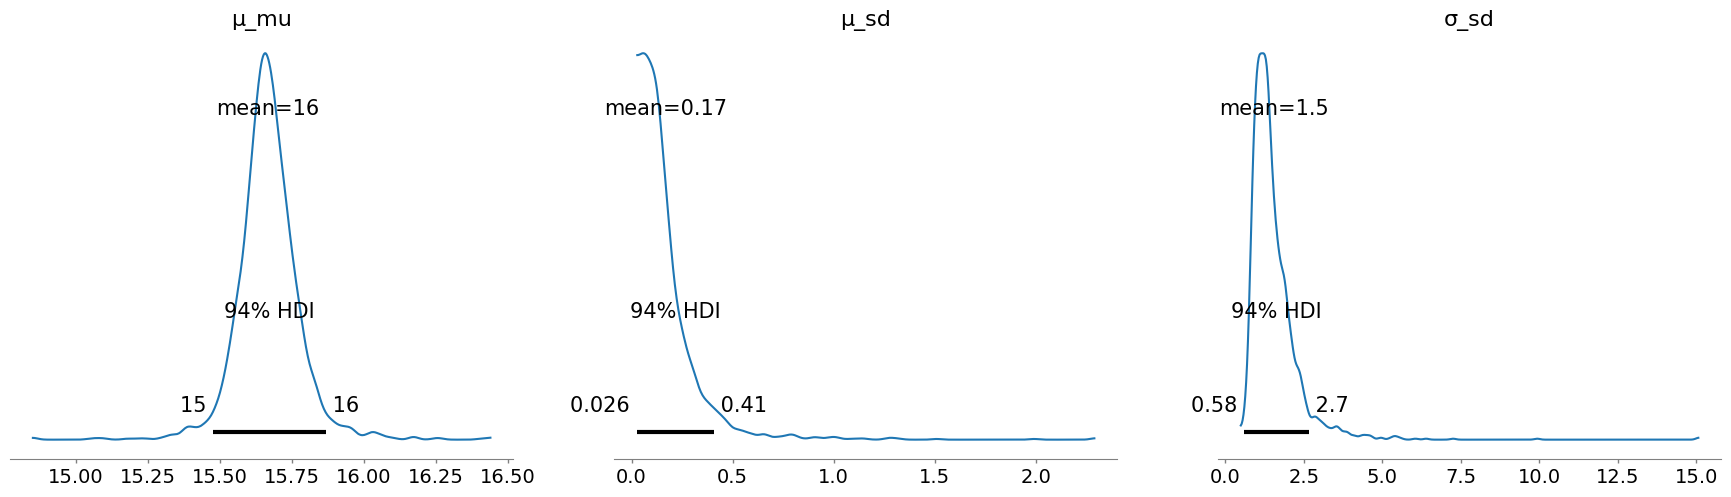

In [95]:
az.plot_posterior(idata_salary, var_names=['μ_mu', 'μ_sd', 'σ_sd'])

In [96]:
pm.sample_posterior_predictive(idata_salary, model=sal_model, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

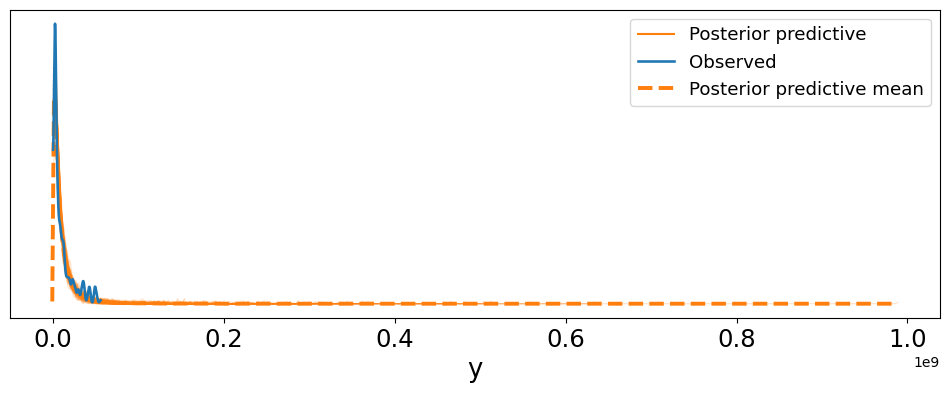

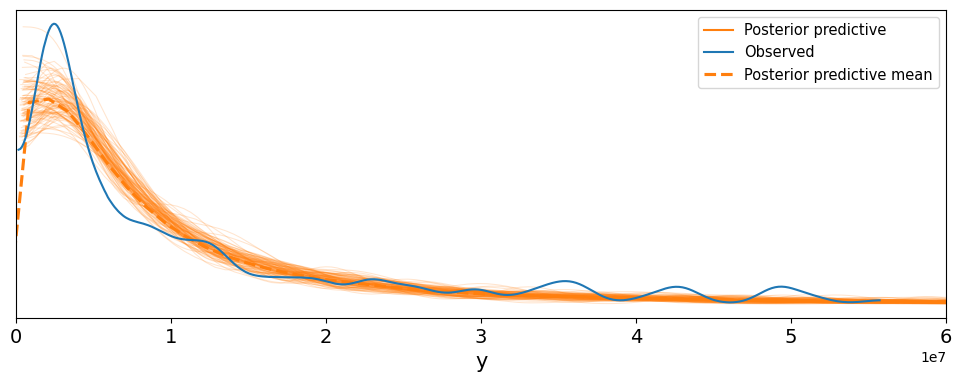

In [97]:
az.plot_ppc(idata_salary, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

fig, ax = plt.subplots(figsize=(12, 4))  # Some extra stuff to restrict the x axis
az.plot_ppc(idata_salary, num_pp_samples=100, colors=["C1", "C0", "C1"], ax=ax)
ax.set_xlim(0, 60000000)
plt.show()

This is weird, because if I jsut look at what the bulk of the individual posterior predictives seem to be doing, they do a pretty good job of modeling the data, especially considering the limited sample size, but the posterior predictive mean does a very bad job for low salary values (also it doesn't really seem to be the mean of the posterior predictives??). Anyways, I think I'll try improving this one more time.